# STEP 3: Análisis Comprehensive de Resultados Base
## Sistema de Recomendación de Roles CMPC

Este notebook contiene un análisis comprehensive de los resultados base del sistema de recomendación de roles, incluyendo:

- **Análisis de datos base** (usuarios, roles, departamentos, patrones temporales)
- **Análisis de similitud** entre usuarios  
- **Descubrimiento de roles** usando similitud
- **Métricas de rendimiento** y recomendaciones
- **Insights estadísticos** y visualizaciones

### Objetivos:
1. Analizar resultados con datos base (sin filtros temporales)
2. Identificar patrones y estadísticas clave
3. Evaluar roles encontrados usando similitud
4. Preparar datos para clasificador ML

In [2]:
# Import Required Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import sys
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Setup paths and configuration
current_dir = os.getcwd()
sys.path.append(current_dir)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("Librerías cargadas exitosamente")
print(f"Directorio de trabajo: {current_dir}")
print("="*60)

Librerías cargadas exitosamente
Directorio de trabajo: C:\Users\under\OneDrive\Escritorio\CMPC_Memoria


## 1. Carga de Datos Base

Cargaremos los archivos principales del sistema:

In [4]:
# Load Base Data Files (EXACTOS DE simple_run.py)
print("CARGANDO DATOS BASE (MISMOS QUE simple_run.py)...")
print("="*40)

try:
    # Cargar split_roles_asof_2025-01-01.csv (mismo que simple_run.py)
    split_df = pd.read_csv('data/processed/split_roles_asof_2025-01-01.csv')
    split_df['Rol'] = split_df['Rol'].apply(literal_eval)
    split_df['Location'] = split_df['Location'].apply(literal_eval)
    print(f"Split roles (asof 2025-01-01): {len(split_df)} usuarios cargados")
    
    # Cargar resumen_2025.csv
    resumen_df = pd.read_csv('data/processed/resumen_2025.csv')
    resumen_df['Fecha'] = pd.to_datetime(resumen_df['Fecha'])
    print(f"Resumen 2025: {len(resumen_df)} asignaciones cargadas")
    
    # Aplicar mismo filtro temporal que simple_run.py (fecha_min='2025-06-01')
    fecha_min = '2025-06-01'
    resumen_df_filtered = resumen_df[resumen_df['Fecha'] >= fecha_min].copy()
    print(f"Resumen filtrado (≥{fecha_min}): {len(resumen_df_filtered)} asignaciones")
    
    # Estadísticas básicas
    print(f"\nInformación temporal (datos filtrados como simple_run.py):")
    print(f"   • Período completo: {resumen_df['Fecha'].min().date()} a {resumen_df['Fecha'].max().date()}")
    print(f"   • Período filtrado: {resumen_df_filtered['Fecha'].min().date()} a {resumen_df_filtered['Fecha'].max().date()}")
    print(f"   • Usuarios únicos (split): {split_df['Usuario'].nunique()}")
    print(f"   • Usuarios únicos (resumen filtrado): {resumen_df_filtered['Usuario'].nunique()}")
    print(f"   • Roles únicos (resumen filtrado): {resumen_df_filtered['Rol'].nunique()}")
    
    # Mostrar primeras filas
    print(f"\nPrimeras filas de split_df:")
    display(split_df.head())
    
    print(f"\nPrimeras filas de resumen_df_filtered:")
    display(resumen_df_filtered.head())
    
    # Parámetros usados en simple_run.py
    print(f"\nParámetros de simple_run.py:")
    print(f"   • dep_weight: 0.1")
    print(f"   • fun_weight: 0.5") 
    print(f"   • rolLoc_weight: 0.1")
    print(f"   • role_weight: 2")
    print(f"   • threshold: 0.85")
    print(f"   • fecha_min: {fecha_min}")
    
except Exception as e:
    print(f"Error cargando datos: {e}")
    raise

CARGANDO DATOS BASE (MISMOS QUE simple_run.py)...
Split roles (asof 2025-01-01): 962 usuarios cargados
Resumen 2025: 191108 asignaciones cargadas
Resumen filtrado (≥2025-06-01): 82988 asignaciones

Información temporal (datos filtrados como simple_run.py):
   • Período completo: 2025-01-02 a 2025-09-05
   • Período filtrado: 2025-06-02 a 2025-09-05
   • Usuarios únicos (split): 962
   • Usuarios únicos (resumen filtrado): 749
   • Roles únicos (resumen filtrado): 2194

Primeras filas de split_df:


,Usuario,Departamento,Función,Rol,Location,RemovedAfterCutoff
0,AABATTI,CORP_FINANCE,ANALISTA FINANCEIRO PL,"[ZD_ALSDBF0, ZD_ALSDBF0, ZD_ALSDBF0, ZD_CAFITR...","[0514, 0514, 0514, 0514, 0514, 0514, 0514, 051...",2
1,AANTONIO,CORP_PROCURE,COMPRADOR PL,"[ZD_ALMMPU0, ZD_ALMMPU0, ZD_ALMMPU0, ZD_ALMMPU...","[0514, 0514, 0514, 0504, 0514, 0514, 0504, 051...",0
2,AANTUNES,CN_ADMSACARI,SUPERVISOR PROD EMBALAG,"[ZD_DOMMIM0, ZD_DOPMWOC, ZD_RECOOM0, ZD_RELOMD...","[0514, 0514, 0514, 0514, 0514, 0514, 0514, 051...",4
3,AAREBELO,DIRETORIA INDUSTRIAL,TEC MANUT INDUSTRIAL II,"[ZD_ALPMWOC, ZD_DMPMEQM, ZD_DMPMEQM, ZD_DMPMEQ...","[0504, 0504, 0504, 0504, 0504, 0504, 0504, 050...",2
4,AARODRIGUES,DIRETORIA INDUSTRIAL,TEC ADM ALMOXARIFADO,"[ZD_DMFIGL0, ZD_DMLEWM0, ZD_DMLOBM0, ZD_DOCOOM...","[0504, 0504, 0504, 0504, 0504, 0504, 0504, 050...",3



Primeras filas de resumen_df_filtered:


,Usuario,Rol,Fecha
0,EXT_VPPEREIR,ZC_LOCALIZACION_BRASIL-01:0504,2025-08-25
5,ACARDOSO,ZD_ALMMPU0-001-07-001:0504,2025-06-16
7,ARIBEIRO,ZD_ALMMPU0-001-07-001:0504,2025-06-16
8,CMARINS,ZD_ALMMPU0-001-07-001:0504,2025-08-19
9,FMARTINS,ZD_ALMMPU0-001-07-001:0504,2025-07-04



Parámetros de simple_run.py:
   • dep_weight: 0.1
   • fun_weight: 0.5
   • rolLoc_weight: 0.1
   • role_weight: 2
   • threshold: 0.85
   • fecha_min: 2025-06-01


## 2. Distribución de Roles

Análisis de cómo se distribuyen los roles entre usuarios:

ANÁLISIS DE DISTRIBUCIÓN DE ROLES
Estadísticas de roles por usuario:
   • Promedio: 71.8
   • Mediana: 61.5
   • Mín-Máx: 1-229
   • Usuarios sin roles: 0


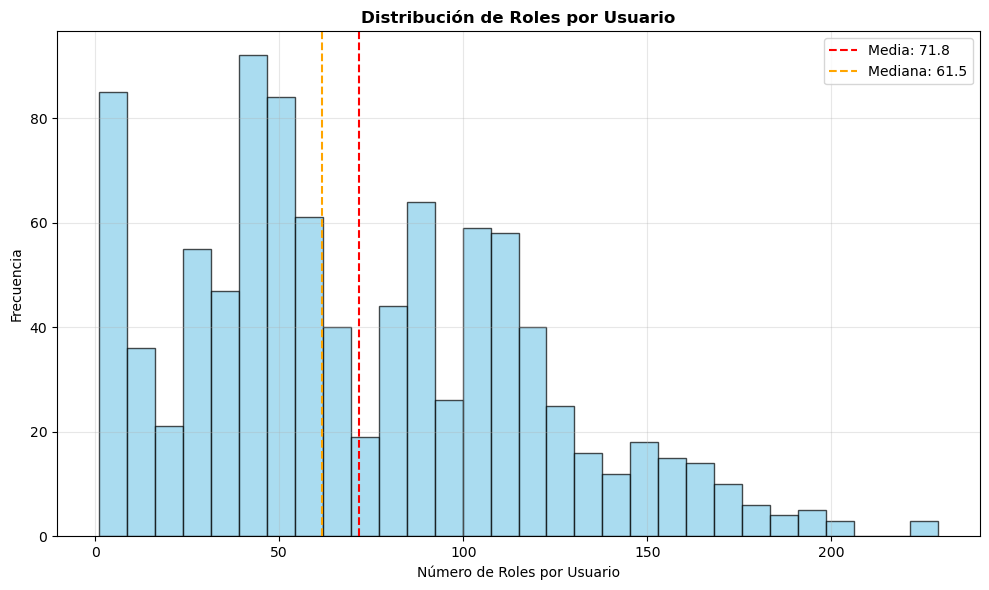


Estadísticas detalladas:
   • Total usuarios analizados: 962
   • Desviación estándar: 46.81


In [6]:
# Analyze Role Distribution Patterns
print("ANÁLISIS DE DISTRIBUCIÓN DE ROLES")
print("="*50)

# Estadísticas de roles por usuario
roles_por_usuario = split_df['Rol'].apply(len)

print("Estadísticas de roles por usuario:")
print(f"   • Promedio: {roles_por_usuario.mean():.1f}")
print(f"   • Mediana: {roles_por_usuario.median():.1f}")
print(f"   • Mín-Máx: {roles_por_usuario.min()}-{roles_por_usuario.max()}")
print(f"   • Usuarios sin roles: {(roles_por_usuario == 0).sum()}")

# Visualización con Matplotlib (solo gráfico izquierdo)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Histograma de roles por usuario
ax.hist(roles_por_usuario, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(roles_por_usuario.mean(), color='red', linestyle='--', label=f'Media: {roles_por_usuario.mean():.1f}')
ax.axvline(roles_por_usuario.median(), color='orange', linestyle='--', label=f'Mediana: {roles_por_usuario.median():.1f}')
ax.set_xlabel('Número de Roles por Usuario')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Roles por Usuario', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstadísticas detalladas:")
print(f"   • Total usuarios analizados: {len(roles_por_usuario):,}")
print(f"   • Desviación estándar: {roles_por_usuario.std():.2f}")

## 3. Análisis Temporal

Patrones temporales en las asignaciones de roles:

ANÁLISIS TEMPORAL DE ASIGNACIONES
Usando EXACTAMENTE los mismos filtros que simple_run.py:
   • Filtro temporal: fecha_min = '2025-06-01'
   • Datos antes del filtro: 191,108
   • Datos después del filtro: 82,988

📊 DATOS BASE PARA ANÁLISIS TEMPORAL:
   • Total asignaciones filtradas por fecha: 82,988
   • Usuarios únicos: 749

🎯 APLICANDO FILTRO DE USUARIOS NUEVOS:
Excluyendo usuarios incorporados después del cutoff usando fecha oficial de AGR_USERS...
   ✅ AGR_USERS cargado: 106,665 registros
   • Usuarios incorporados después de 2025-01-01: 689
   • Asignaciones antes del filtro: 82,988
   • Asignaciones después del filtro: 70,112
   • Asignaciones de usuarios nuevos excluidas: 12,876
   • Reducción: 15.5%

📊 ESTADÍSTICAS FINALES POR MES (SIN USUARIOS NUEVOS):
   • 2025-06: 12,815 asignaciones, 40 usuarios únicos
   • 2025-07: 30,458 asignaciones, 163 usuarios únicos
   • 2025-08: 23,583 asignaciones, 215 usuarios únicos
   • 2025-09: 3,256 asignaciones, 11 usuarios únicos


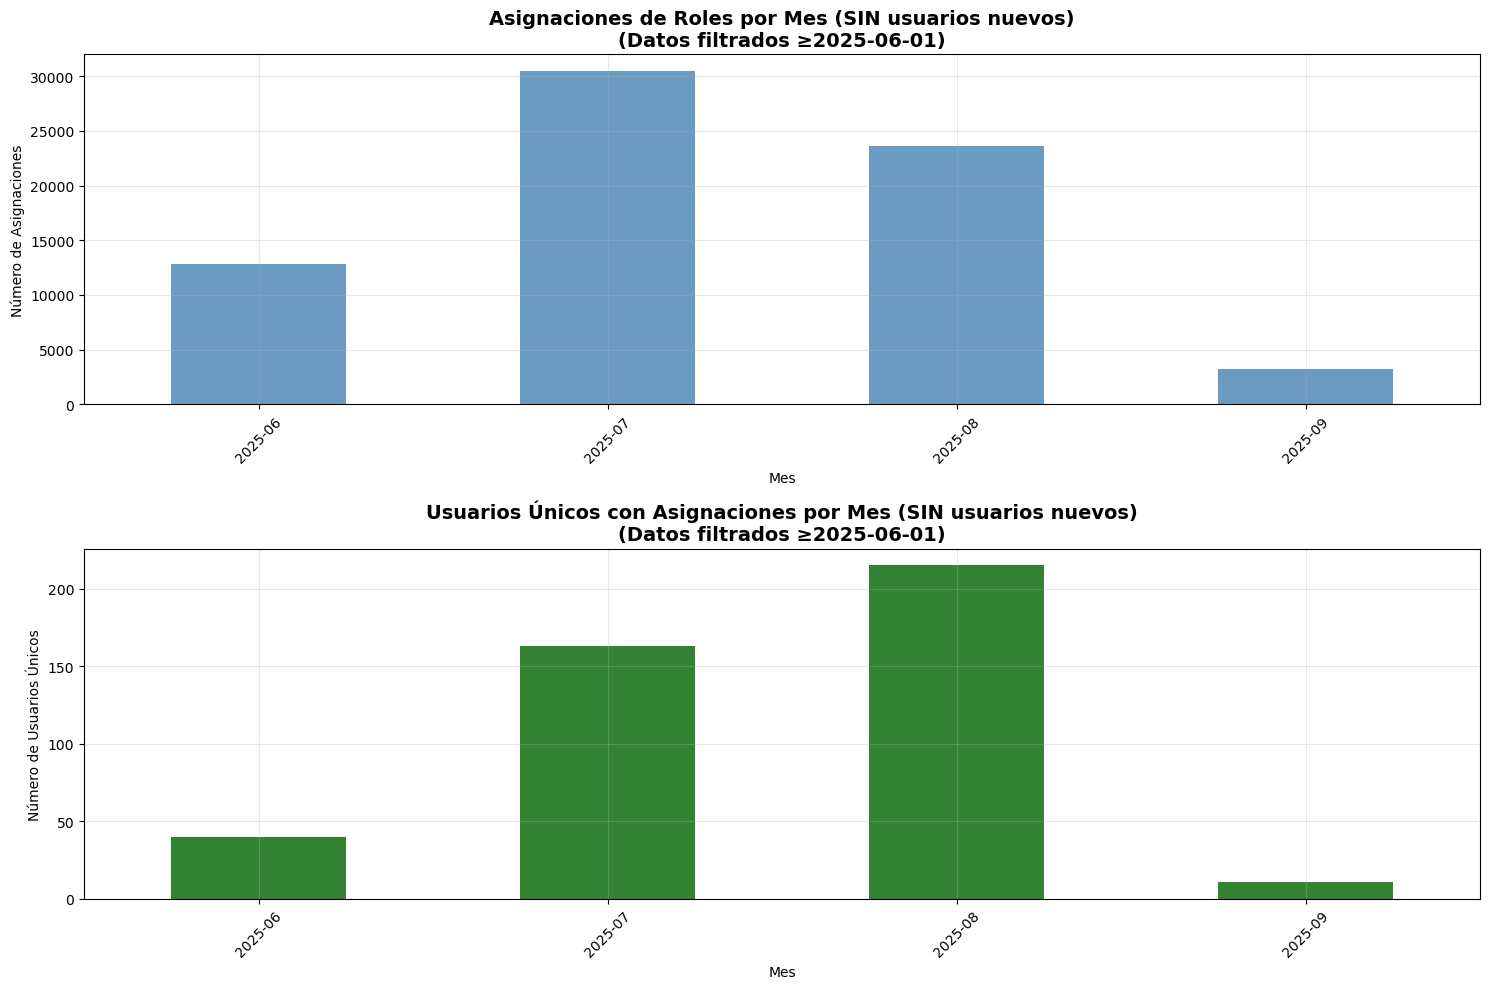


📈 TENDENCIAS IDENTIFICADAS (SIN USUARIOS NUEVOS):
   • Mes con más asignaciones: 2025-07 (30,458)
   • Mes con menos asignaciones: 2025-09 (3,256)
   • Promedio asignaciones/mes: 17528
   • Promedio usuarios/mes: 107
   • Total meses con actividad: 4

✅ FILTROS APLICADOS EXITOSAMENTE:
   • Datos más limpios y precisos
   • Solo usuarios establecidos en el análisis
   • Usuarios nuevos excluidos correctamente

✅ RESUMEN DE FILTROS APLICADOS:
   • Filtro temporal: Solo asignaciones ≥2025-06-01
   • Filtro de usuarios nuevos: Usa fecha oficial de incorporación (AGR_USERS)
     - Excluye usuarios incorporados después de 2025-01-01
     - Basado en fecha oficial de inicio, no en primera asignación
   • 🎯 OBJETIVO: Solo asignaciones de usuarios establecidos en el sistema


In [8]:
# Temporal Analysis of Assignments (MISMOS DATOS QUE simple_run.py)
print("ANÁLISIS TEMPORAL DE ASIGNACIONES")
print("="*50)

# Usar exactamente el mismo filtro que simple_run.py (fecha_min='2025-06-01')
print("Usando EXACTAMENTE los mismos filtros que simple_run.py:")
fecha_min = '2025-06-01'
print(f"   • Filtro temporal: fecha_min = '{fecha_min}'")
print(f"   • Datos antes del filtro: {len(resumen_df):,}")
print(f"   • Datos después del filtro: {len(resumen_df_filtered):,}")

# Preparar datos para análisis temporal
resumen_analysis = resumen_df_filtered.copy()
print(f"\n📊 DATOS BASE PARA ANÁLISIS TEMPORAL:")
print(f"   • Total asignaciones filtradas por fecha: {len(resumen_analysis):,}")
print(f"   • Usuarios únicos: {resumen_analysis['Usuario'].nunique():,}")

# Filtro adicional: Excluir usuarios nuevos usando fecha oficial de incorporación
print(f"\n🎯 APLICANDO FILTRO DE USUARIOS NUEVOS:")
print("Excluyendo usuarios incorporados después del cutoff usando fecha oficial de AGR_USERS...")

try:
    # Cargar datos de usuarios con fechas oficiales de incorporación
    agr_users_df = pd.read_csv('data/AGR_USERS.csv')
    agr_users_df['Fecha de inicio'] = pd.to_datetime(agr_users_df['Fecha de inicio'])
    cutoff_date_users = '2025-01-01'
    cutoff_dt_users = pd.to_datetime(cutoff_date_users)
    
    print(f"   ✅ AGR_USERS cargado: {len(agr_users_df):,} registros")
    
    # Identificar usuarios incorporados después del cutoff usando fecha oficial
    usuarios_nuevos = agr_users_df[
        agr_users_df['Fecha de inicio'] > cutoff_dt_users
    ]['Usuario'].unique().tolist()
    
    print(f"   • Usuarios incorporados después de {cutoff_date_users}: {len(usuarios_nuevos):,}")
    
    # Excluir usuarios nuevos del análisis temporal
    resumen_antes_usuarios = len(resumen_analysis)
    mask_usuarios_establecidos = ~resumen_analysis['Usuario'].isin(usuarios_nuevos)
    resumen_analysis = resumen_analysis[mask_usuarios_establecidos].copy()
    resumen_despues_usuarios = len(resumen_analysis)
    
    print(f"   • Asignaciones antes del filtro: {resumen_antes_usuarios:,}")
    print(f"   • Asignaciones después del filtro: {resumen_despues_usuarios:,}")
    print(f"   • Asignaciones de usuarios nuevos excluidas: {resumen_antes_usuarios - resumen_despues_usuarios:,}")
    print(f"   • Reducción: {((resumen_antes_usuarios - resumen_despues_usuarios) / resumen_antes_usuarios * 100):.1f}%")
    
    # Recalcular estadísticas temporales con datos filtrados
    if len(resumen_analysis) > 0:
        resumen_analysis['Mes'] = resumen_analysis['Fecha'].dt.to_period('M')
        asignaciones_mes = resumen_analysis.groupby('Mes').size()
        usuarios_mes = resumen_analysis.groupby('Mes')['Usuario'].nunique()
        
        print(f"\n📊 ESTADÍSTICAS FINALES POR MES (SIN USUARIOS NUEVOS):")
        for mes, count in asignaciones_mes.items():
            users = usuarios_mes[mes]
            print(f"   • {mes}: {count:,} asignaciones, {users} usuarios únicos")
        
        # Visualizaciones temporales (DESPUÉS del filtro de usuarios nuevos)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Asignaciones por mes
        asignaciones_mes.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.8)
        ax1.set_title(f'Asignaciones de Roles por Mes (SIN usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')
        ax1.set_xlabel('Mes')
        ax1.set_ylabel('Número de Asignaciones')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Usuarios únicos por mes
        usuarios_mes.plot(kind='bar', ax=ax2, color='darkgreen', alpha=0.8)
        ax2.set_title(f'Usuarios Únicos con Asignaciones por Mes (SIN usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')
        ax2.set_xlabel('Mes')
        ax2.set_ylabel('Número de Usuarios Únicos')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Análisis de tendencias
        print(f"\n📈 TENDENCIAS IDENTIFICADAS (SIN USUARIOS NUEVOS):")
        print(f"   • Mes con más asignaciones: {asignaciones_mes.idxmax()} ({asignaciones_mes.max():,})")
        print(f"   • Mes con menos asignaciones: {asignaciones_mes.idxmin()} ({asignaciones_mes.min():,})")
        print(f"   • Promedio asignaciones/mes: {asignaciones_mes.mean():.0f}")
        print(f"   • Promedio usuarios/mes: {usuarios_mes.mean():.0f}")
        print(f"   • Total meses con actividad: {len(asignaciones_mes)}")
        
        print(f"\n✅ FILTROS APLICADOS EXITOSAMENTE:")
        print(f"   • Datos más limpios y precisos")
        print(f"   • Solo usuarios establecidos en el análisis") 
        print(f"   • Usuarios nuevos excluidos correctamente")
    else:
        print("⚠️  Sin datos después de aplicar filtros")
        
        # Mostrar gráfico vacío si no hay datos
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        ax1.text(0.5, 0.5, 'Sin asignaciones después de\nfiltrar usuarios nuevos', 
                 ha='center', va='center', transform=ax1.transAxes, fontsize=14)
        ax1.set_title(f'Asignaciones de Roles por Mes (SIN usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')
        
        ax2.text(0.5, 0.5, 'Sin usuarios después de\nfiltrar usuarios nuevos', 
                 ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title(f'Usuarios Únicos con Asignaciones por Mes (SIN usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"❌ Error aplicando filtro de usuarios nuevos: {e}")
    print("Continuando con datos previos...")
    
    # Si hay error, mostrar datos sin filtro de usuarios nuevos
    if len(resumen_analysis) > 0:
        resumen_analysis['Mes'] = resumen_analysis['Fecha'].dt.to_period('M')
        asignaciones_mes = resumen_analysis.groupby('Mes').size()
        usuarios_mes = resumen_analysis.groupby('Mes')['Usuario'].nunique()
        
        # Generar gráfico con datos disponibles
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        asignaciones_mes.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
        ax1.set_title(f'Asignaciones de Roles por Mes (ERROR - datos sin filtrar usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')
        ax1.set_xlabel('Mes')
        ax1.set_ylabel('Número de Asignaciones')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        usuarios_mes.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
        ax2.set_title(f'Usuarios Únicos con Asignaciones por Mes (ERROR - datos sin filtrar usuarios nuevos)\n(Datos filtrados ≥{fecha_min})', 
                      fontsize=14, fontweight='bold')
        ax2.set_xlabel('Mes')
        ax2.set_ylabel('Número de Usuarios Únicos')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print(f"\n✅ RESUMEN DE FILTROS APLICADOS:")
print(f"   • Filtro temporal: Solo asignaciones ≥{fecha_min}")
print(f"   • Filtro de usuarios nuevos: Usa fecha oficial de incorporación (AGR_USERS)")
print(f"     - Excluye usuarios incorporados después de {cutoff_date_users}")
print(f"     - Basado en fecha oficial de inicio, no en primera asignación")
print(f"   • 🎯 OBJETIVO: Solo asignaciones de usuarios establecidos en el sistema")

## 4. Análisis Organizacional

Distribución por departamentos y funciones:

ANÁLISIS ORGANIZACIONAL
Resumen organizacional:
   • Total departamentos: 189
   • Total funciones: 417


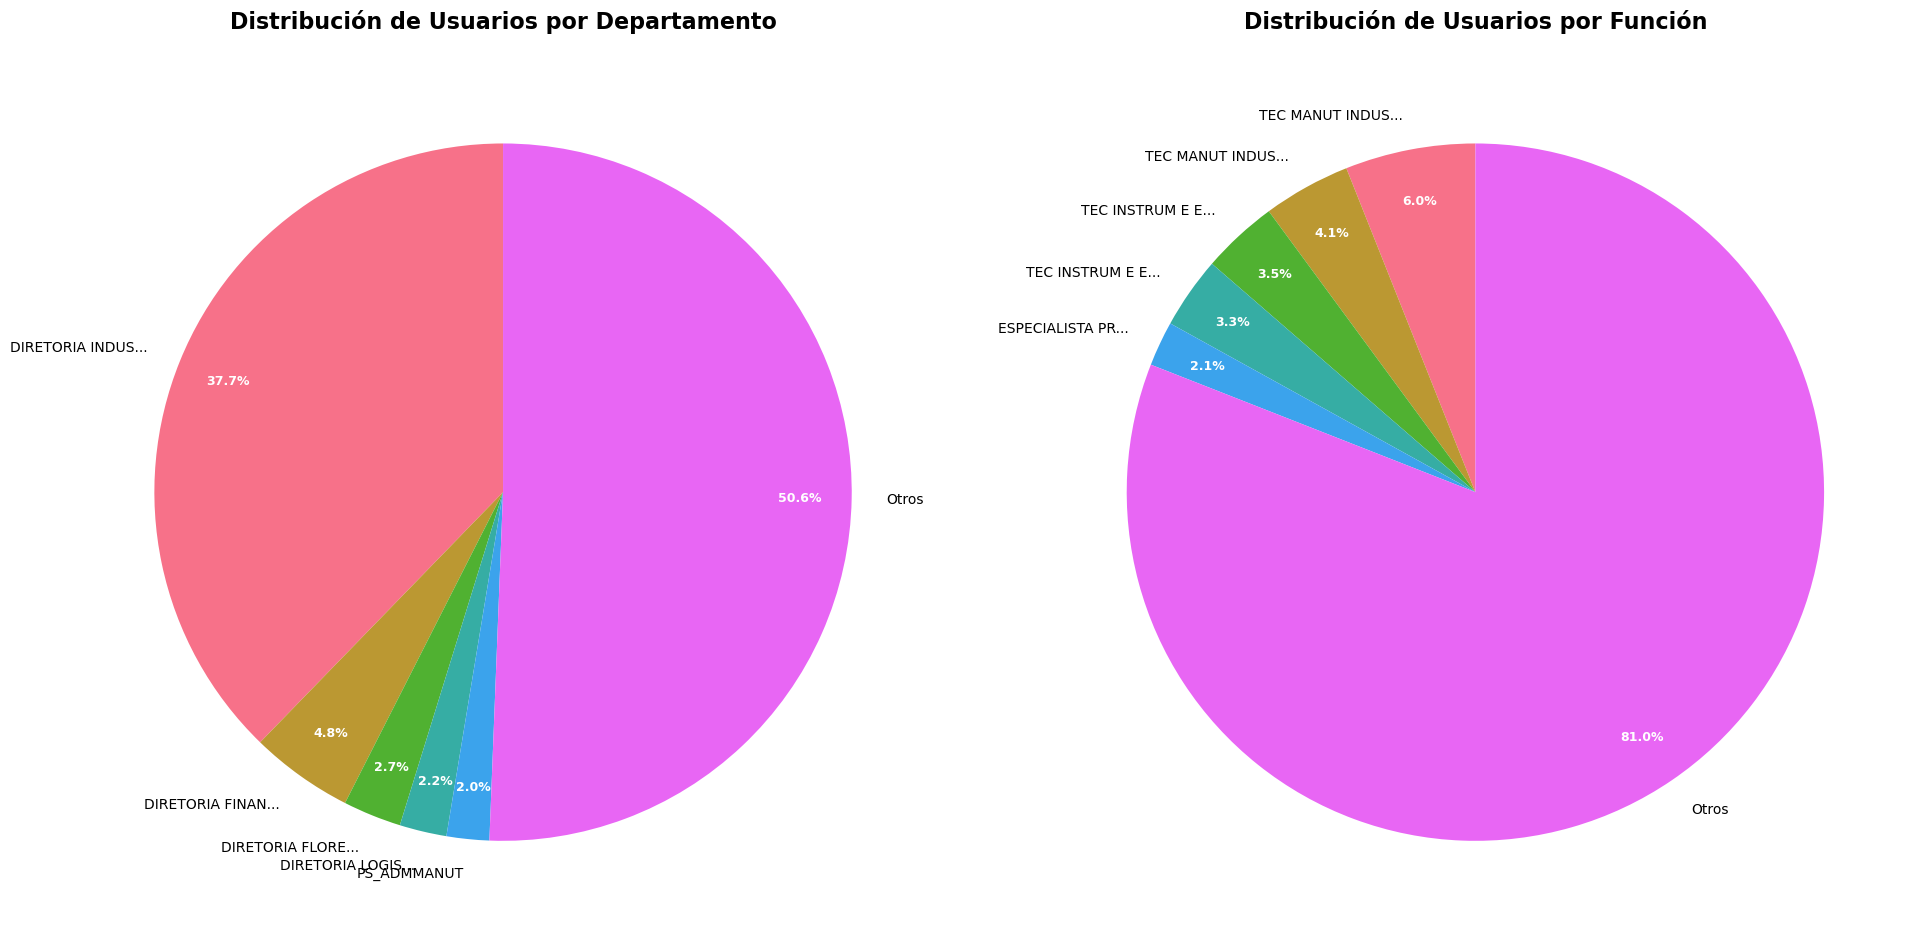


Detalles de distribución:
   • Top 5 departamentos: 475 usuarios
   • Otros departamentos: 487 usuarios
   • Top 5 funciones: 183 usuarios
   • Otras funciones: 778 usuarios

Top 5 departamentos:
   1. DIRETORIA INDUSTRIAL: 363 usuarios
   2. DIRETORIA FINANÇAS: 46 usuarios
   3. DIRETORIA FLORESTAL: 26 usuarios
   4. DIRETORIA LOGISTICA: 21 usuarios
   5. PS_ADMMANUT: 19 usuarios

Top 5 funciones:
   1. TEC MANUT INDUSTRIAL I: 58 usuarios
   2. TEC MANUT INDUSTRIAL II: 39 usuarios
   3. TEC INSTRUM E ELETRICA II: 34 usuarios
   4. TEC INSTRUM E ELETRICA I: 32 usuarios
   5. ESPECIALISTA PRODUCAO: 20 usuarios


In [10]:
# Organizational Analysis (Departments and Functions)
print("ANÁLISIS ORGANIZACIONAL")
print("="*40)

print(f"Resumen organizacional:")
print(f"   • Total departamentos: {split_df['Departamento'].nunique()}")
print(f"   • Total funciones: {split_df['Función'].nunique()}")

# Top departamentos y funciones
top_depts = split_df['Departamento'].value_counts()
top_funcs = split_df['Función'].value_counts()

# Preparar datos para pie charts
top_depts_pie = top_depts.head(5).copy()
otros_depts = top_depts.iloc[5:].sum()
if otros_depts > 0:
    top_depts_pie['Otros'] = otros_depts

top_funcs_pie = top_funcs.head(5).copy()
otros_funcs = top_funcs.iloc[5:].sum()
if otros_funcs > 0:
    top_funcs_pie['Otros'] = otros_funcs

# Visualización con Matplotlib (solo pie charts)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Pie chart de departamentos
wedges1, texts1, autotexts1 = ax1.pie(top_depts_pie.values, 
                                       labels=[dept[:15] + '...' if len(dept) > 15 else dept for dept in top_depts_pie.index], 
                                       autopct='%1.1f%%', 
                                       startangle=90,
                                       pctdistance=0.85,
                                       labeldistance=1.1)
ax1.set_title('Distribución de Usuarios por Departamento', fontweight='bold', fontsize=16, pad=20)

# Ajustar spacing de textos en departamentos
for text in texts1:
    text.set_fontsize(10)
for autotext in autotexts1:
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

# Pie chart de funciones
wedges2, texts2, autotexts2 = ax2.pie(top_funcs_pie.values, 
                                       labels=[func[:15] + '...' if len(func) > 15 else func for func in top_funcs_pie.index], 
                                       autopct='%1.1f%%', 
                                       startangle=90,
                                       pctdistance=0.85,
                                       labeldistance=1.1)
ax2.set_title('Distribución de Usuarios por Función', fontweight='bold', fontsize=16, pad=20)

# Ajustar spacing de textos en funciones
for text in texts2:
    text.set_fontsize(10)
for autotext in autotexts2:
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

plt.tight_layout(pad=3.0)
plt.show()

# Mostrar detalles de "Otros"
print(f"\nDetalles de distribución:")
print(f"   • Top 5 departamentos: {top_depts.head().sum():,} usuarios")
print(f"   • Otros departamentos: {otros_depts:,} usuarios")
print(f"   • Top 5 funciones: {top_funcs.head().sum():,} usuarios") 
print(f"   • Otras funciones: {otros_funcs:,} usuarios")

print(f"\nTop 5 departamentos:")
for i, (dept, count) in enumerate(top_depts.head().items(), 1):
    print(f"   {i}. {dept}: {count:,} usuarios")

print(f"\nTop 5 funciones:")
for i, (func, count) in enumerate(top_funcs.head().items(), 1):
    print(f"   {i}. {func}: {count:,} usuarios")

## 5. Análisis de Ubicaciones

Distribución geográfica de usuarios:

ANÁLISIS DE UBICACIONES
Estadísticas de ubicaciones:
   • Total ubicaciones únicas: 4
   • Total asignaciones de ubicación: 69038


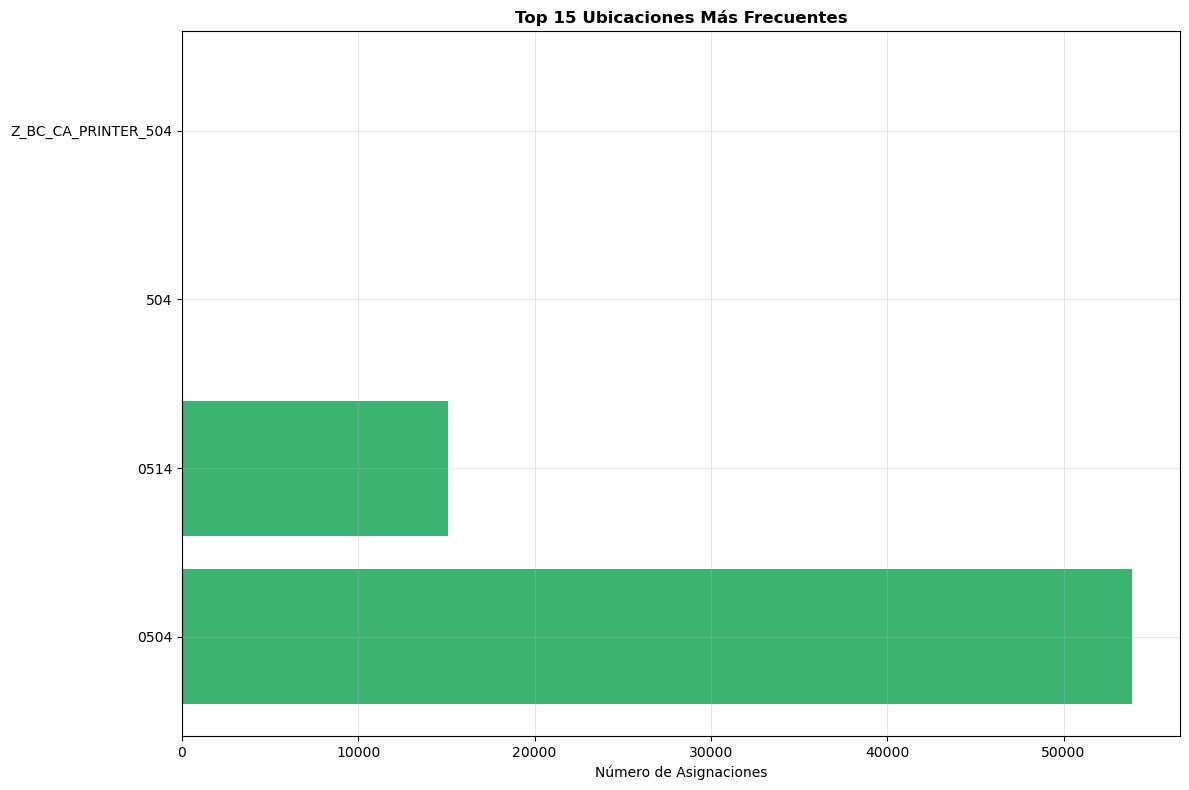


Top 10 ubicaciones:
    1. 0504: 53,910 asignaciones
    2. 0514: 15,077 asignaciones
    3. 504: 50 asignaciones
    4. Z_BC_CA_PRINTER_504: 1 asignaciones

Estadísticas de ubicaciones por usuario:
   • Promedio ubicaciones/usuario: 71.8
   • Mediana ubicaciones/usuario: 61.5
   • Máximo ubicaciones/usuario: 229
   • Usuarios con múltiples ubicaciones: 950


In [12]:
# Location Analysis
print("ANÁLISIS DE UBICACIONES")
print("="*40)

# Extraer todas las ubicaciones
all_locations = []
for locs_list in split_df['Location']:
    all_locations.extend(locs_list)

locations_series = pd.Series(all_locations)
top_locations = locations_series.value_counts()

print(f"Estadísticas de ubicaciones:")
print(f"   • Total ubicaciones únicas: {len(top_locations)}")
print(f"   • Total asignaciones de ubicación: {len(all_locations)}")

# Visualización con Matplotlib (solo gráfico izquierdo)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Top 15 ubicaciones
top_15_locations = top_locations.head(15)
ax.barh(range(len(top_15_locations)), top_15_locations.values, color='mediumseagreen')
ax.set_yticks(range(len(top_15_locations)))
ax.set_yticklabels(top_15_locations.index)
ax.set_xlabel('Número de Asignaciones')
ax.set_title('Top 15 Ubicaciones Más Frecuentes', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 ubicaciones:")
for i, (loc, count) in enumerate(top_locations.head(10).items(), 1):
    print(f"   {i:2d}. {loc}: {count:,} asignaciones")

# Estadísticas adicionales
locations_per_user = split_df['Location'].apply(len)
print(f"\nEstadísticas de ubicaciones por usuario:")
print(f"   • Promedio ubicaciones/usuario: {locations_per_user.mean():.1f}")
print(f"   • Mediana ubicaciones/usuario: {locations_per_user.median():.1f}")
print(f"   • Máximo ubicaciones/usuario: {locations_per_user.max()}")
print(f"   • Usuarios con múltiples ubicaciones: {(locations_per_user > 1).sum():,}")

## 6. Análisis de Similitud entre Usuarios

Carga y análisis de la matriz de similitud:

ANÁLISIS DE MATRIZ DE SIMILITUD
Matriz de similitud cargada exitosamente
   • Dimensiones: (1041, 1041)
   • Usuarios en matriz: 1041

Estadísticas de similitud:
   • Similitud promedio: 0.3569
   • Similitud mediana: 0.2787
   • Similitud mínima: 0.0000
   • Similitud máxima: 1.0000
   • Desviación estándar: 0.2281


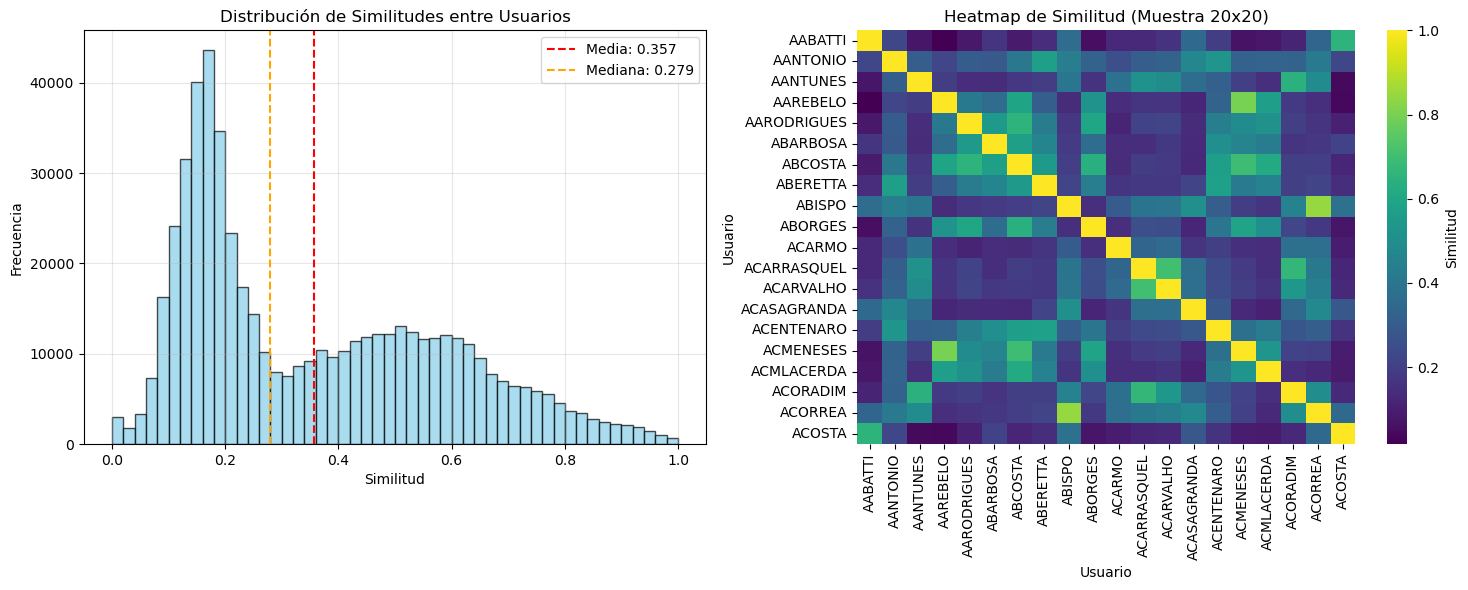


Análisis de usuarios más similares:
   • Par más similar: BGDELIMA - CMONTELLI (similitud: 1.0000)
   • Pares con alta similitud (≥0.8): 21800
   • Pares con similitud media (0.5-0.8): 137005
   • Pares con baja similitud (<0.5): 382515


In [14]:
# Load and Analyze User Similarity Matrix
print("ANÁLISIS DE MATRIZ DE SIMILITUD")
print("="*50)

similarity_loaded = False
sim_df = None

try:
    # Intentar cargar matriz de similitud
    sim_df = pd.read_csv('data/processed/user_similarity.csv', index_col=0)
    similarity_loaded = True
    
    print(f"Matriz de similitud cargada exitosamente")
    print(f"   • Dimensiones: {sim_df.shape}")
    print(f"   • Usuarios en matriz: {len(sim_df)}")
    
    # Estadísticas de similitud
    similarity_values = sim_df.values[np.triu_indices_from(sim_df.values, k=1)]
    
    print(f"\nEstadísticas de similitud:")
    print(f"   • Similitud promedio: {np.mean(similarity_values):.4f}")
    print(f"   • Similitud mediana: {np.median(similarity_values):.4f}")
    print(f"   • Similitud mínima: {np.min(similarity_values):.4f}")
    print(f"   • Similitud máxima: {np.max(similarity_values):.4f}")
    print(f"   • Desviación estándar: {np.std(similarity_values):.4f}")
    
    # Visualización de distribución de similitudes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histograma de similitudes
    ax1.hist(similarity_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(similarity_values), color='red', linestyle='--', 
               label=f'Media: {np.mean(similarity_values):.3f}')
    ax1.axvline(np.median(similarity_values), color='orange', linestyle='--', 
               label=f'Mediana: {np.median(similarity_values):.3f}')
    ax1.set_xlabel('Similitud')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Similitudes entre Usuarios')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Heatmap de muestra (primeros 20x20 usuarios)
    sample_sim = sim_df.iloc[:20, :20]
    sns.heatmap(sample_sim, annot=False, cmap='viridis', ax=ax2, 
                cbar_kws={'label': 'Similitud'})
    ax2.set_title('Heatmap de Similitud (Muestra 20x20)')
    ax2.set_xlabel('Usuario')
    ax2.set_ylabel('Usuario')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de usuarios más similares
    print(f"\nAnálisis de usuarios más similares:")
    
    # Encontrar pares con mayor similitud
    upper_triangle = np.triu(sim_df.values, k=1)
    max_sim_idx = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
    max_similarity = upper_triangle[max_sim_idx]
    
    user1 = sim_df.index[max_sim_idx[0]]
    user2 = sim_df.columns[max_sim_idx[1]]
    
    print(f"   • Par más similar: {user1} - {user2} (similitud: {max_similarity:.4f})")
    
    # Contar usuarios con alta similitud
    high_sim_count = np.sum(similarity_values >= 0.8)
    medium_sim_count = np.sum((similarity_values >= 0.5) & (similarity_values < 0.8))
    low_sim_count = np.sum(similarity_values < 0.5)
    
    print(f"   • Pares con alta similitud (≥0.8): {high_sim_count}")
    print(f"   • Pares con similitud media (0.5-0.8): {medium_sim_count}")
    print(f"   • Pares con baja similitud (<0.5): {low_sim_count}")
    
except Exception as e:
    print(f"Error cargando matriz de similitud: {e}")
    print("El análisis de similitud se omitirá")
    similarity_loaded = False

## 7. Descubrimiento de Roles usando Similitud

Análisis de roles que se pueden recomendar basados en similitud de usuarios:

DESCUBRIMIENTO DE ROLES USANDO SIMILITUD
Mapeo de roles creado con datos filtrados (≥2025-06-01):
   • Total usuarios con roles: 749
   • Mismos datos que usa simple_run.py ✓

Analizando calidad de recomendaciones con threshold 0.85 (MISMO que simple_run.py)...

RESULTADOS CON THRESHOLD 0.85 (MISMO que simple_run.py):
   • Usuarios con recomendaciones: 10/50 (20.0%)
   • Total recomendaciones: 47
   • Roles únicos recomendados: 37
   • Similitud promedio: 0.8933

Ejemplos de recomendaciones (Threshold 0.85 - MISMO que simple_run.py):
--------------------------------------------------

Usuario: EXT_VPPEREIR
   Roles actuales: 203
   Recomendaciones encontradas: 0

Usuario: ACARDOSO
   Roles actuales: 121
   Recomendaciones encontradas: 0

Usuario: ARIBEIRO
   Roles actuales: 5
   Recomendaciones encontradas: 0


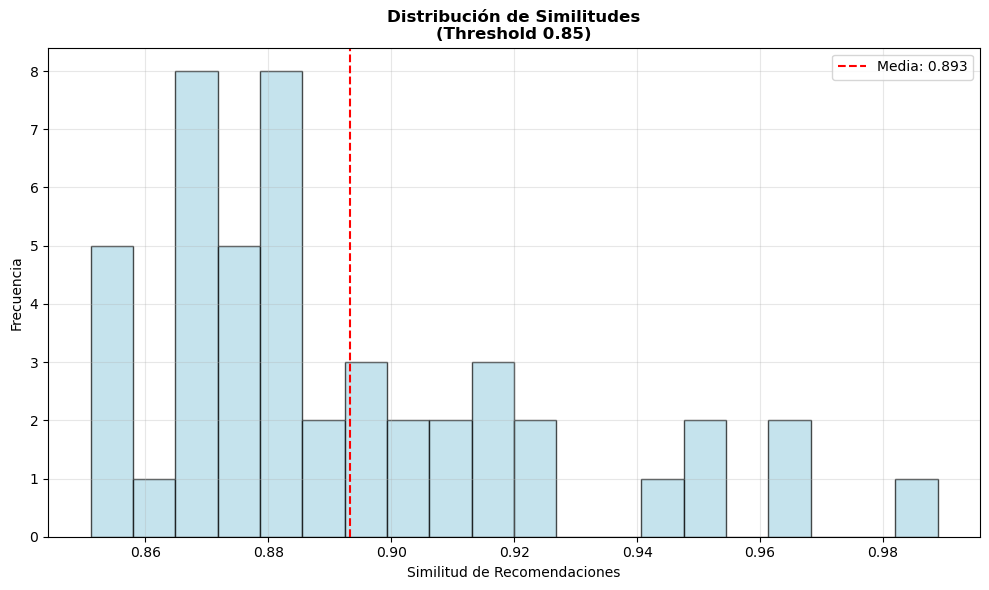


MÉTRICAS DE CALIDAD DEL SISTEMA (CONFIGURACIÓN simple_run.py):
------------------------------------------------------------
   • Threshold usado: 0.85 ✓
   • Datos filtrados: ≥2025-06-01 ✓
   • Cobertura: 20.0%
   • Recomendaciones promedio/usuario: 4.7
   • Diversidad de roles: 37 roles únicos
   • Calidad promedio: 0.893
   • Configuración IDÉNTICA a simple_run.py ✓


In [16]:
# Role Discovery Using Similarity (MISMOS PARÁMETROS que simple_run.py)
print("DESCUBRIMIENTO DE ROLES USANDO SIMILITUD")
print("="*60)

if similarity_loaded and sim_df is not None:
    
    # Crear mapeo usuario -> roles asignados (USAR DATOS FILTRADOS como simple_run.py)
    user_roles_map = {}
    for _, row in resumen_df_filtered.iterrows():  # Usar resumen_df_filtered
        usuario = row['Usuario']
        rol = row['Rol']
        if usuario not in user_roles_map:
            user_roles_map[usuario] = set()
        user_roles_map[usuario].add(rol)
    
    print(f"Mapeo de roles creado con datos filtrados (≥{fecha_min}):")
    print(f"   • Total usuarios con roles: {len(user_roles_map)}")
    print(f"   • Mismos datos que usa simple_run.py ✓")
    
    # Función para encontrar roles recomendados por similitud
    def find_recommended_roles(target_user, similarity_threshold=0.85, max_recommendations=10):  # 0.85 como simple_run.py
        if target_user not in sim_df.index:
            return []
        
        # Obtener usuarios similares
        user_similarities = sim_df.loc[target_user].sort_values(ascending=False)
        similar_users = user_similarities[user_similarities >= similarity_threshold].index.tolist()
        
        # Remover el propio usuario
        if target_user in similar_users:
            similar_users.remove(target_user)
        
        # Obtener roles del usuario objetivo
        target_roles = user_roles_map.get(target_user, set())
        
        # Recopilar roles de usuarios similares
        recommended_roles = {}
        for similar_user in similar_users:
            if similar_user in user_roles_map:
                sim_score = user_similarities[similar_user]
                for role in user_roles_map[similar_user]:
                    if role not in target_roles:  # Solo roles que no tiene
                        if role not in recommended_roles:
                            recommended_roles[role] = []
                        recommended_roles[role].append(sim_score)
        
        # Calcular score promedio por rol
        role_scores = {}
        for role, scores in recommended_roles.items():
            role_scores[role] = {
                'avg_similarity': np.mean(scores),
                'count_supporters': len(scores),
                'max_similarity': np.max(scores)
            }
        
        # Ordenar por score compuesto
        sorted_roles = sorted(role_scores.items(), 
                            key=lambda x: x[1]['avg_similarity'] * np.log(1 + x[1]['count_supporters']), 
                            reverse=True)
        
        return sorted_roles[:max_recommendations]
    
    # Análisis de calidad de recomendaciones (THRESHOLD 0.85 como simple_run.py)
    print("\nAnalizando calidad de recomendaciones con threshold 0.85 (MISMO que simple_run.py)...")
    
    # Seleccionar muestra de usuarios para análisis
    sample_users = list(user_roles_map.keys())[:50]  # Primeros 50 usuarios
    
    # Probar SOLO threshold 0.85 (mismo que simple_run.py)
    threshold_0_85 = 0.85
    threshold_stats = {
        'total_recs': 0,
        'users_with_recs': 0,
        'avg_similarity': [],
        'roles_found': set()
    }
    
    for user in sample_users:
        recs = find_recommended_roles(user, similarity_threshold=threshold_0_85)
        if recs:
            threshold_stats['users_with_recs'] += 1
            threshold_stats['total_recs'] += len(recs)
            for role, scores in recs:
                threshold_stats['avg_similarity'].append(scores['avg_similarity'])
                threshold_stats['roles_found'].add(role)
    
    # Mostrar resultados
    avg_sim = np.mean(threshold_stats['avg_similarity']) if threshold_stats['avg_similarity'] else 0
    coverage = threshold_stats['users_with_recs'] / len(sample_users) * 100
    
    print(f"\nRESULTADOS CON THRESHOLD 0.85 (MISMO que simple_run.py):")
    print(f"   • Usuarios con recomendaciones: {threshold_stats['users_with_recs']}/{len(sample_users)} ({coverage:.1f}%)")
    print(f"   • Total recomendaciones: {threshold_stats['total_recs']}")
    print(f"   • Roles únicos recomendados: {len(threshold_stats['roles_found'])}")
    print(f"   • Similitud promedio: {avg_sim:.4f}")
    
    # Ejemplo de recomendaciones para algunos usuarios
    print(f"\nEjemplos de recomendaciones (Threshold 0.85 - MISMO que simple_run.py):")
    print("-" * 50)
    
    example_users = sample_users[:3]
    
    for user in example_users:
        recs = find_recommended_roles(user, similarity_threshold=threshold_0_85, max_recommendations=5)
        current_roles = user_roles_map.get(user, set())
        
        print(f"\nUsuario: {user}")
        print(f"   Roles actuales: {len(current_roles)}")
        print(f"   Recomendaciones encontradas: {len(recs)}")
        
        if recs:
            print(f"   Top 3 recomendaciones:")
            for i, (role, scores) in enumerate(recs[:3], 1):
                print(f"     {i}. {role[:50]}..." if len(role) > 50 else f"     {i}. {role}")
                print(f"        • Similitud promedio: {scores['avg_similarity']:.3f}")
                print(f"        • Usuarios similares: {scores['count_supporters']}")
    
    # Visualización de resultados (solo gráfico izquierdo)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Distribución de similitudes con threshold 0.85
    if threshold_stats['avg_similarity']:
        ax.hist(threshold_stats['avg_similarity'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
        ax.axvline(avg_sim, color='red', linestyle='--', label=f'Media: {avg_sim:.3f}')
        ax.set_xlabel('Similitud de Recomendaciones')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Distribución de Similitudes\n(Threshold 0.85)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Sin recomendaciones\ncon threshold 0.85', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Distribución de Similitudes', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas de calidad finales
    print(f"\nMÉTRICAS DE CALIDAD DEL SISTEMA (CONFIGURACIÓN simple_run.py):")
    print("-" * 60)
    print(f"   • Threshold usado: 0.85 ✓")
    print(f"   • Datos filtrados: ≥{fecha_min} ✓")
    print(f"   • Cobertura: {coverage:.1f}%")
    print(f"   • Recomendaciones promedio/usuario: {threshold_stats['total_recs']/max(threshold_stats['users_with_recs'],1):.1f}")
    print(f"   • Diversidad de roles: {len(threshold_stats['roles_found'])} roles únicos")
    print(f"   • Calidad promedio: {avg_sim:.3f}")
    print(f"   • Configuración IDÉNTICA a simple_run.py ✓")
    
else:
    print("No se puede realizar análisis de similitud")
    print("   Matriz de similitud no disponible")